### Pipeline for a single spikeglx session
- For every run in the session:
 - Load the recordings
 - Extract wav chan with micrhopohone and make a wav chan with the nidq syn signal
 - Get the sync events for the nidq sync channel
 
 - Do bout detection
 
In another notebook, bout detection is curated
- Left to decide where to:
    - Sort spikes
    - Sync the spikes/lfp/nidq
    - make and plot 'bout rasters'

In [1]:
%matplotlib inline

import os
import glob
import logging
import pickle
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy import signal
import traceback
import warnings

from matplotlib import pyplot as plt
from importlib import reload

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)


In [2]:
from ceciestunepipe.file import bcistructure as et
from ceciestunepipe.util import sglxutil as sglu
from ceciestunepipe.util import rigutil as ru

from ceciestunepipe.util.spikeextractors import preprocess as pre
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import readSGLX as rsgl
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import spikeglxrecordingextractor as sglex


h5py version > 2.10.0. Some extractors might not work properly. It is recommended to downgrade to version 2.10.0: 
>>> pip install h5py==2.10.0


In [3]:
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
logger.info('all modules loaded')

2021-09-18 10:24:44,318 root         INFO     all modules loaded


In [4]:
### Session parameters and raw files

In [5]:
reload(et)

bird = 's_b1253_21'
all_bird_sess = et.list_sessions(bird)
#all_bird_sess

In [12]:
reload(et)
# for one example session

sess_par = {'bird': 's_b1253_21',
           'sess': '2021-06-14',
           'probes': ['probe_0'], #probes of interest
           'mic_list': ['microphone_0'], #list of mics of interest, by signal name in rig.json
           'sort': 2}

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sort=sess_par['sort'])

ksort_folder = exp_struct['folders']['ksort']
raw_folder = exp_struct['folders']['sglx']

In [13]:
raw_folder

'/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx'

In [14]:
sess_epochs = et.list_sgl_epochs(sess_par)
sess_epochs

2021-09-18 11:41:42,965 ceciestunepipe.file.bcistructure INFO     {'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1253_21', 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14', 'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx', 'kwik': '/experiment/s_b1253_21/sglx/kwik/2021-06-14', 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1253_21/2021-06-14/sglx', 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx', 'tmp': '/experiment/tmp/tmp', 'msort': '/experiment/tmp/s_b1253_21/sglx/msort/2021-06-14', 'ksort': '/experiment/tmp/s_b1253_21/sglx/ksort/2021-06-14'}, 'files': {'par': '/experiment/tmp/s_b1253_21/sglx/ksort/2021-06-14/params.json', 'set': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/settings.isf', 'rig': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/rig.json', 'kwd': '/experiment/s_b1253_21/sglx/kwik/2021-06-14/stream.kwd', 'kwik': '/experiment/s_b1253_21/sglx/kwik/2021-06-14/sort_2/s

['0712_g0', '1255_g0', '1740_g0', '2118_g0']

In [19]:
from ceciestunepipe.util import wavutil as wu
from ceciestunepipe.util import syncutil as su

def preprocess_run(sess_par, exp_struct, epoch):
    # get the recordings
    logger.info('PREPROCESSING sess {} | epoch {}'.format(sess_par['sess'], epoch))
    logger.info('getting extractors')
    sgl_exp_struct = et.sgl_struct(sess_par, epoch)
    run_recs_dict, run_meta_files, files_pd, rig_dict = pre.load_sglx_recordings(sgl_exp_struct, epoch)
    
    # get the microphone to wav
    # get the chans
    mic_list = sess_par['mic_list']
    logger.info('Getting microphone channel(s) {}'.format(mic_list))
    mic_stream = pre.extract_nidq_channels(sess_par, run_recs_dict, rig_dict, mic_list, chan_type='adc')
    # get the sampling rate
    nidq_s_f = run_recs_dict['nidq'].get_sampling_frequency()
    
    mic_file_path = os.path.join(sgl_exp_struct['folders']['derived'], 'wav_mic.wav')
    wav_s_f = wu.save_wav(mic_stream, nidq_s_f, mic_file_path)
    
   
    # get the syn to wav
    # get the chans
    sync_list = ['sync']
    logger.info('Getting sync channel(s) {}'.format(sync_list))
    sync_stream = pre.extract_nidq_channels(sess_par, run_recs_dict, rig_dict, sync_list, chan_type='ttl')
    
    sync_file_path = os.path.join(sgl_exp_struct['folders']['derived'], 'wav_sync.wav')
    wav_s_f = wu.save_wav(sync_stream, nidq_s_f, sync_file_path)
    
    logger.info('Getting sync events from the wav sync channel')
    sync_ev_path = os.path.join(sgl_exp_struct['folders']['derived'], 'wav_sync_evt.npy')
    wav_s_f, x_d, ttl_arr = wu.wav_to_syn(sync_file_path)
    logger.info('saving sync events of the wav channel to {}'.format(sync_ev_path))
    np.save(sync_ev_path, ttl_arr)
    
    t_0_path = os.path.join(sgl_exp_struct['folders']['derived'], 'wav_t0.npy')
    logger.info('saving t0 for wav channel to {}'.format(t_0_path))
    np.save(t_0_path, np.arange(sync_stream.size)/wav_s_f)
    #make the sync dict
    syn_dict = {'s_f': wav_s_f,
           't_0_path': t_0_path,
           'evt_arr_path': sync_ev_path}
    
    syn_dict_path = os.path.join(sgl_exp_struct['folders']['derived'],  '{}_sync_dict.pkl'.format('wav'))
    logger.info('saving sync dict to ' + syn_dict_path)
    with open(syn_dict_path, 'wb') as pf:
        pickle.dump(syn_dict, pf)

    epoch_dict = {'epoch': epoch,
                'files_pd': files_pd,
                 'recordings': run_recs_dict,
                 'meta': run_meta_files,
                 'rig': rig_dict}
    
    return epoch_dict

    
one_epoch_dict = preprocess_run(sess_par, exp_struct, sess_epochs[0])

2021-09-18 12:34:08,912 root         INFO     PREPROCESSING sess 2021-06-14 | epoch 0712_g0
2021-09-18 12:34:08,914 root         INFO     getting extractors
2021-09-18 12:34:31,068 root         INFO     Getting microphone channel(s) ['microphone_0']
2021-09-18 12:34:31,134 ceciestunepipe.util.wavutil INFO     sampling rate 20000
2021-09-18 12:34:31,134 ceciestunepipe.util.wavutil INFO     saving (1, 411700466)-shaped array as wav in /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/0712_g0/wav_mic.wav
2021-09-18 12:36:02,965 ceciestunepipe.util.wavutil INFO     saving (1, 411700466)-shaped array as npy in /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/0712_g0/wav_mic.npy
2021-09-18 12:36:24,983 root         INFO     Getting sync channel(s) ['sync']
2021-09-18 12:36:24,984 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl traces, chan range(0, 7)
2021-09-18 12:36:36,859 ceciestunepipe.ut

In [22]:
### sequentially process all runs of the sessions
def preprocess_session(sess_par: dict):
    logger.info('pre-process all runs of sess ' + sess_par['sess'])
    # get exp struct
    sess_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sort=sess_par['sort'])
    # list the epochs
    sess_epochs = et.list_sgl_epochs(sess_par)
    logger.info('found epochs: {}'.format(sess_epochs))
    # preprocess all epochs
    epoch_dict_list = []
    for i_ep, epoch in enumerate(sess_epochs):
        try:
            exp_struct = et.sgl_struct(sess_par, epoch)
            one_epoch_dict = preprocess_run(sess_par, exp_struct, epoch)
            epoch_dict_list.append(one_epoch_dict)
        except Exception as exc:
            warnings.warn('Error in epoch {}'.format(epoch), UserWarning)
            logger.info(traceback.format_exc)
            logger.info(exc)
            logger.info('Session {} epoch {} could not be preprocessed'.format(sess_par['sess'], epoch))
        
    return epoch_dict_list

#all_epoch_list = preprocess_session(sess_par)

#### Process multiple sessions

In [23]:
sess_list = all_bird_sess
# fist implant, right hemisphere
sess_list = ['2021-06-14', '2021-06-13', '2021-06-15', '2021-06-16', '2021-06-17']

# second implant, left hemisphere
#sess_list = ['2021-07-17', '2021-07-18', '2021-07-19', '2021-07-20', '2021-07-21', '2021-07-22', '2021-07-23'] 
# and up to 8/4but only up to 19 are on sphere as of 2021-09-09; the rest on tapes

In [24]:
all_sess_dict = {}

for one_sess in sess_list[:]:
    sess_par['sess'] = one_sess
    preprocess_session(sess_par)

2021-09-18 12:51:20,437 root         INFO     pre-process all runs of sess 2021-06-14
2021-09-18 12:51:20,439 ceciestunepipe.file.bcistructure INFO     {'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1253_21', 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14', 'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx', 'kwik': '/experiment/s_b1253_21/sglx/kwik/2021-06-14', 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1253_21/2021-06-14/sglx', 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx', 'tmp': '/experiment/tmp/tmp', 'msort': '/experiment/tmp/s_b1253_21/sglx/msort/2021-06-14', 'ksort': '/experiment/tmp/s_b1253_21/sglx/ksort/2021-06-14'}, 'files': {'par': '/experiment/tmp/s_b1253_21/sglx/ksort/2021-06-14/params.json', 'set': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/settings.isf', 'rig': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-06-14/sglx/rig.json', 'kwd': '/experiment/s_b1253_21/sglx/kwik

In [28]:
sess_par

{'bird': 's_b1253_21',
 'sess': '2021-07-17',
 'probes': ['probe_0'],
 'mic_list': ['microphone_0'],
 'sort': 2}

In [ ]:
# Search bouts

## search bouts for those sessions

In [29]:
from ceciestunepipe.util.sound import boutsearch as bs
from ceciestunepipe.util import wavutil as wu

from joblib import Parallel, delayed
import pickle
import sys

In [30]:
reload(bs)

<module 'ceciestunepipe.util.sound.boutsearch' from '/home/finch/repos/ceciestunepipe/ceciestunepipe/util/sound/boutsearch.py'>

In [31]:
def sess_file_id(f_path):
    n = int(os.path.split(f_path)[1].split('-')[-1].split('.wav')[0])
    return n

def get_all_day_bouts(sess_par: dict, hparams:dict, n_jobs: int=12, ephys_software='sglx', 
                     parallel=True) -> pd.DataFrame:
    
    logger.info('Will search for bouts through all session {}, {}'.format(sess_par['bird'], sess_par['sess']))
    exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], ephys_software=ephys_software)

    # get all the paths to the wav files of the epochs of the day   
    source_folder = exp_struct['folders']['derived']
    wav_path_list = et.get_sgl_files_epochs(source_folder, file_filter='*wav_mic.wav')
    wav_path_list.sort()
    logger.info('Found {} files'.format(len(wav_path_list)))
    print(wav_path_list)
    
    def get_file_bouts(i_path):
        epoch_bout_pd = bs.get_bouts_in_long_file(i_path, hparams)[0]
        
        i_folder = os.path.split(i_path)[0]
        epoch_bouts_path = os.path.join(i_folder, hparams['bout_auto_file'])
        hparams_pickle_path = os.path.join(i_folder, 'bout_search_params.pickle')

        logger.info('saving bout detect parameters dict to ' + hparams_pickle_path)
        with open(hparams_pickle_path, 'wb') as fh:
            save_param = hparams.copy()
            save_param['read_wav_fun'] = save_param['read_wav_fun'].__name__
            save_param['file_order_fun'] = save_param['file_order_fun'].__name__
            
            pickle.dump(save_param, fh)
        
        logger.info('saving bouts pandas to ' + epoch_bouts_path)
        epoch_bout_pd.to_pickle(epoch_bouts_path)

        #epoch_bout_pd = pd.DataFrame()
        return epoch_bout_pd
    
    # Go parallel through all the paths in the day, get a list of all the pandas dataframes for each file
    if parallel:
        sess_pd_list = Parallel(n_jobs=n_jobs, verbose=100, backend=None)(delayed(get_file_bouts)(i) for i in wav_path_list)
    else:
        sess_pd_list = [get_file_bouts(i) for i in wav_path_list]
    
    #concatenate the file and return it, eventually write to a pickle
    sess_bout_pd = pd.concat(sess_pd_list)
    return sess_bout_pd

def save_auto_bouts(sess_bout_pd, sess_par, hparams):
    exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], ephys_software='sglx')
    sess_bouts_dir = os.path.join(exp_struct['folders']['derived'], 'bouts_ceciestunepipe')

    sess_bouts_path = os.path.join(sess_bouts_dir, hparams['bout_auto_file'])
    hparams_pickle_path = os.path.join(sess_bouts_dir, 'bout_search_params.pickle')

    os.makedirs(sess_bouts_dir, exist_ok=True)
    logger.info('saving bouts pandas to ' + sess_bouts_path)
    sess_bout_pd.to_pickle(sess_bouts_path)

    logger.info('saving bout detect parameters dict to ' + hparams_pickle_path)
    with open(hparams_pickle_path, 'wb') as fh:
        pickle.dump(hparams, fh)

In [32]:
## need to enter 'sample_rate' from the file!
hparams = {
    # spectrogram
    'num_freq':1024, #1024# how many channels to use in a spectrogram #
    'preemphasis':0.97, 
    'frame_shift_ms':5, # step size for fft
    'frame_length_ms':10, #128 # frame length for fft FRAME SAMPLES < NUM_FREQ!!!
    'min_level_db':-55, # minimum threshold db for computing spe 
    'ref_level_db':110, # reference db for computing spec
    #'sample_rate':None, # sample rate of your data
    
    # spectrograms
    'mel_filter': False, # should a mel filter be used?
    'num_mels':1024, # how many channels to use in the mel-spectrogram
    'fmin': 500, # low frequency cutoff for mel filter
    'fmax': 12000, # high frequency cutoff for mel filter
    
    # spectrogram inversion
    'max_iters':200,
    'griffin_lim_iters':20,
    'power':1.5,

    # Added for the searching
    'read_wav_fun': wu.read_wav_chan, # function for loading the wav_like_stream (has to returns fs, ndarray)
    'file_order_fun': sess_file_id, # function for extracting the file id within the session
    'min_segment': 30, # Minimum length of supra_threshold to consider a 'syllable' (ms)
    'min_silence': 2000, # Minmum distance between groups of syllables to consider separate bouts (ms)
    'min_bout': 5000, # min bout duration (ms)
    'peak_thresh_rms': 0.55, # threshold (rms) for peak acceptance,
    'thresh_rms': 0.25, # threshold for detection of syllables
    'mean_syl_rms_thresh': 0.3, #threshold for acceptance of mean rms across the syllable (relative to rms of the file)
    'max_bout': 120000, #exclude bouts too long
    'l_p_r_thresh': 100, # threshold for n of len_ms/peaks (typycally about 2-3 syllable spans
    
    'waveform_edges': 1000, #get number of ms before and after the edges of the bout for the waveform sample
    
    'bout_auto_file': 'bout_auto.pickle', # extension for saving the auto found files
    'bout_curated_file': 'bout_checked.pickle', #extension for manually curated files (coming soon)
    }

In [ ]:
bird_bouts_folder = os.path.abspath('/mnt/sphere/speech_bci/processed_data/s_b1253_21/bouts_wav')

In [38]:
exp_struct['folders']['derived']

'/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-02/sglx'

In [39]:
all_sessions = sess_list[:2]

for sess in all_sessions:
    sess_par['sess'] = sess
    sess_bout_pd = get_all_day_bouts(sess_par, hparams, parallel=False)
    save_auto_bouts(sess_bout_pd, sess_par, hparams)
    sess_bouts_folder = os.path.join(exp_struct['folders']['derived'], 'bouts')
    bouts_to_wavs(sess_bout_pd, sess_par, hparams, sess_bouts_folder)

2021-09-14 19:23:31,978 root         INFO     Will search for bouts through all session s_b1253_21, 2021-07-17
2021-09-14 19:23:32,370 root         INFO     Found 4 files
2021-09-14 19:23:32,371 ceciestunepipe.util.sound.boutsearch INFO     Getting bouts for long file /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/0738_g0/wav_mic.wav


['/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/0738_g0/wav_mic.wav', '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/0957_g0/wav_mic.wav', '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/1206_g0/wav_mic.wav', '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/1648_g0/wav_mic.wav']
tu vieja file /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/0738_g0/wav_mic.wav


2021-09-14 19:23:32,589 ceciestunepipe.util.sound.boutsearch INFO     splitting file into 3 chunks


  0%|          | 0/3 [00:00<?, ?it/s]

2021-09-14 19:26:39,834 root         INFO     saving bout detect parameters dict to /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/0738_g0/bout_search_params.pickle
2021-09-14 19:26:39,844 root         INFO     saving bouts pandas to /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/0738_g0/bout_auto.pickle
2021-09-14 19:26:39,962 ceciestunepipe.util.sound.boutsearch INFO     Getting bouts for long file /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/0957_g0/wav_mic.wav


tu vieja file /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/0957_g0/wav_mic.wav


2021-09-14 19:26:40,001 ceciestunepipe.util.sound.boutsearch INFO     splitting file into 3 chunks


  0%|          | 0/3 [00:00<?, ?it/s]

2021-09-14 19:29:35,826 root         INFO     saving bout detect parameters dict to /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/0957_g0/bout_search_params.pickle
2021-09-14 19:29:35,837 root         INFO     saving bouts pandas to /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/0957_g0/bout_auto.pickle
2021-09-14 19:29:35,914 ceciestunepipe.util.sound.boutsearch INFO     Getting bouts for long file /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/1206_g0/wav_mic.wav


tu vieja file /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/1206_g0/wav_mic.wav


2021-09-14 19:29:35,945 ceciestunepipe.util.sound.boutsearch INFO     splitting file into 5 chunks


  0%|          | 0/5 [00:00<?, ?it/s]

2021-09-14 19:35:29,945 root         INFO     saving bout detect parameters dict to /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/1206_g0/bout_search_params.pickle
2021-09-14 19:35:30,258 root         INFO     saving bouts pandas to /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/1206_g0/bout_auto.pickle
2021-09-14 19:35:30,384 ceciestunepipe.util.sound.boutsearch INFO     Getting bouts for long file /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/1648_g0/wav_mic.wav


tu vieja file /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/1648_g0/wav_mic.wav


2021-09-14 19:35:30,497 ceciestunepipe.util.sound.boutsearch INFO     splitting file into 7 chunks


  0%|          | 0/7 [00:00<?, ?it/s]

2021-09-14 19:42:23,344 root         INFO     saving bout detect parameters dict to /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/1648_g0/bout_search_params.pickle
2021-09-14 19:42:23,396 root         INFO     saving bouts pandas to /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/1648_g0/bout_auto.pickle
2021-09-14 19:42:23,517 root         INFO     saving bouts pandas to /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/bouts_ceciestunepipe/bout_auto.pickle
2021-09-14 19:42:24,042 root         INFO     saving bout detect parameters dict to /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/bouts_ceciestunepipe/bout_search_params.pickle


NameError: name 'bouts_to_wavs' is not defined

## debug the above


In [ ]:
def get_all_day_bouts(sess_par: dict, hparams:dict, n_jobs: int=12, ephys_software='sglx', 
                     parallel=True) -> pd.DataFrame:
    
    logger.info('Will search for bouts through all session {}, {}'.format(sess_par['bird'], sess_par['sess']))
    exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], ephys_software=ephys_software)

    # get all the paths to the wav files of the epochs of the day   
    source_folder = exp_struct['folders']['derived']
    wav_path_list = et.get_sgl_files_epochs(source_folder, file_filter='*wav_mic.wav')
    wav_path_list.sort()
    logger.info('Found {} files'.format(len(wav_path_list)))
    print(wav_path_list)
    
    def get_file_bouts(i_path):
        epoch_bout_pd = bs.get_bouts_in_long_file(i_path, hparams)[0]
        
        i_folder = os.path.split(i_path)[0]
        epoch_bouts_path = os.path.join(i_folder, hparams['bout_auto_file'])
        hparams_pickle_path = os.path.join(i_folder, 'bout_search_params.pickle')

        logger.info('saving bout detect parameters dict to ' + hparams_pickle_path)
        with open(hparams_pickle_path, 'wb') as fh:
            save_param = hparams.copy()
            save_param['read_wav_fun'] = save_param['read_wav_fun'].__name__
            save_param['file_order_fun'] = save_param['file_order_fun'].__name__
            
            pickle.dump(save_param, fh)
        
        logger.info('saving bouts pandas to ' + epoch_bouts_path)
        epoch_bout_pd.to_pickle(epoch_bouts_path)

        #epoch_bout_pd = pd.DataFrame()
        return epoch_bout_pd
    
    # Go parallel through all the paths in the day, get a list of all the pandas dataframes for each file
    if parallel:
        sess_pd_list = Parallel(n_jobs=n_jobs, verbose=100, backend=None)(delayed(get_file_bouts)(i) for i in wav_path_list)
    else:
        sess_pd_list = [get_file_bouts(i) for i in wav_path_list]
    
    #concatenate the file and return it, eventually write to a pickle
    sess_bout_pd = pd.concat(sess_pd_list)
    return sess_bout_pd

In [23]:
!ls /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/0738_g0/

bout_auto.pickle	   wav_mic.npy	wav_sync_evt.npy  wav_sync.wav
bout_search_params.pickle  wav_mic.wav	wav_sync.npy


In [21]:
def read_wav_chan(wav_path: str, chan_id: int=0) -> tuple:
    s_f, x = wavfile.read(wav_path, mmap=False)
    if x.ndim==1:
        if chan_id > 0:
            raise ValueError('Wave file has only one channel, asking for channel {}'.format(chan_id))
        x = x.reshape(-1, 1)
    
    return s_f, x[:, chan_id]

mic_path = '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/0738_g0/wav_mic.wav'
mic_sf, mic_stream = read_wav_chan(mic_path)
hparams['sample_rate'] = mic_sf

ValueError: File format b'' not understood. Only 'RIFF' and 'RIFX' supported.

In [51]:
mic_stream.shape

(207854592,)

In [52]:
bs.get_bouts_in_long_file(mic_path, hparams)

2021-09-14 16:20:15,786 ceciestunepipe.util.sound.boutsearch INFO     Getting bouts for long file /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/0738_g0/wav_mic.wav


tu vieja file /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-17/sglx/0738_g0/wav_mic.wav


2021-09-14 16:20:15,875 ceciestunepipe.util.sound.boutsearch INFO     splitting file into 3 chunks


  0%|          | 0/3 [00:00<?, ?it/s]

(    start_ms   end_ms  start_sample  end_sample  \
 0      64130    70200       1603250     1755000   
 1     119385   126220       2984625     3155500   
 2     162225   173615       4055625     4340375   
 3     215610   222495       5390250     5562375   
 4     226340   232365       5658500     5809125   
 5     326570   341115       8164250     8527875   
 6     751425   758645      18785625    18966125   
 7     797025   803695      19925625    20092375   
 8     812240   817800      20306000    20445000   
 9     844495   852345      21112375    21308625   
 10    864845   875400      21621125    21885000   
 11   1785960  1792080      44649000    44802000   
 12   2047630  2053100      51190750    51327500   
 13   2594500  2600110      64862500    65002750   
 14   2676065  2681575      66901625    67039375   
 15   2698755  2704095      67468875    67602375   
 0    2803834  2811499      70095850    70287475   
 1    2901734  2906929      72543350    72673225   
 2    403954

In [44]:
hparams['frame_shift_ms']

5

In [45]:
hparams['sample_rate']

In [43]:
bs.get_the_bouts(mic_stream[:30000*2000], hparams)

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [88]:
exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sort=sess_par['sort'])
exp_struct

{'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1253_21',
  'raw': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-18',
  'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-18/sglx',
  'kwik': '/scratch/earneodo/s_b1253_21/sglx/kwik/2021-07-18',
  'processed': '/mnt/sphere/speech_bci/processed_data/s_b1253_21/2021-07-18/sglx',
  'derived': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-18/sglx',
  'tmp': '/scratch/earneodo/tmp',
  'msort': '/scratch/earneodo/s_b1253_21/sglx/msort/2021-07-18',
  'ksort': '/scratch/earneodo/s_b1253_21/sglx/ksort/2021-07-18'},
 'files': {'par': '/scratch/earneodo/s_b1253_21/sglx/ksort/2021-07-18/params.json',
  'set': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-18/sglx/settings.isf',
  'rig': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-18/sglx/rig.json',
  'kwd': '/scratch/earneodo/s_b1253_21/sglx/kwik/2021-07-18/stream.kwd',
  'kwik': '/scratch/earneodo/s_b1253_21/sglx/kwik/2021-07-18/sort_2/spikes.kwik',
  

In [64]:
nidq_syn_stream = run_recordings['nidq'].get_ttl_traces()[sync_chan, :]

2021-08-23 16:15:42,464 ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor.spikeglxrecordingextractor INFO     getting ttl events, chan range(0, 7)


In [63]:
nidq_ttl[sync_chan, :]

array([[0, 0, 0, ..., 1, 1, 1]], dtype=int16)

In [ ]:
nidq_syn_stream = run_recordings['nidq'].get_traces(channel_ids=mic_chan_id)

In [ ]:
s_f_nidq = run_recordings['nidq']._s_f_0
s_f_ap = run_recordings['ap_0']._s_f_0

### load the bout and spike data
- TODO: save extractor pickle files in the sglx_pipe-dev-sort-bouts
- Load the bout pkl file (already synched to spikes)
- Load the spikes 

In [19]:
# load the bouts file
bout_dict_path = os.path.join(exp_struct['folders']['derived'], 'bout_dict.pkl')

with open(bout_dict_path, 'rb') as handle:
    bout_dict = pickle.load(handle)
    
bout_dict

{'template': memmap([ -275,  -258,  -245, ..., -1737, -1734, -1750], dtype=int16),
 's_f': 20000,
 's_f_nidq': 19999.75,
 's_f_ap_0': 30000.0,
 'start_ms': array([   15670,    64840,   111020,   179460,   283670,   369580,
          412450,   463160,  1327100,  1375900,  1422920,  1476900,
         1512130,  1585770,  1625000,  1909140,  1970400,  2019310,
         2653600,  2767500,  3010180,  3130470,  3213900,  3274500,
         3331000,  3383830,  3447100,  3849700,  3878390,  3919670,
         3973890,  4028380,  4136000,  4227180,  4321500,  4993970,
         5110290,  5263800,  5439420,  5560350,  6410950,  6718500,
         6771670, 16330800, 16385500, 17007440, 17237000, 17388300]),
 'len_ms': array([37010, 29739, 35610, 37030, 29449, 28370, 33170, 28939, 34000,
        32719, 34079, 24199, 27209, 25860, 25789, 40589, 34500, 37289,
        32000, 48920, 31970, 51390, 30639, 30679, 33000, 29869, 29200,
        27420, 20510, 32029, 31910, 35039, 44199, 42769, 41720, 43279,
     

In [20]:
### load the spikes from pickle
spike_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'spk_df.pickle')
clu_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'clu_df.pickle')

spk_df = pd.read_pickle(spike_pickle_path)
clu_df = pd.read_pickle(clu_pickle_path)

spk_df.head(3)

times  clusters nucelus  main_chan kslabel
0    104        64      ra         78    good
1    120        21      ra         27    good
2    139        72      ra         90    good

In [21]:
## plot some example waveform

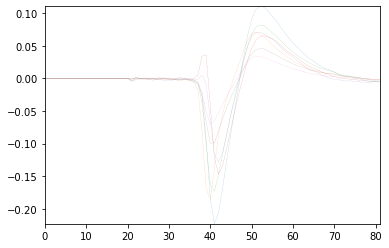

In [35]:
plt.plot(clu_df.loc[40, 'main_wav_7']);

# Plot spikes/audio

In [23]:
plt.rcParams['lines.linewidth'] = 0.1
from ceciestunepipe.util.sound import spectral as sp
from ceciestunepipe.util import plotutil as pu

In [24]:
def get_window_spikes(spk_df, clu_list, start_sample, end_sample):
    onset = start_sample
    offset = end_sample
    
    spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]
    
    spk_arr = np.zeros((clu_list.size, offset - onset))

    for i, clu_id in enumerate(clu_list):
        clu_spk_t = spk_t.loc[spk_t['clusters']==clu_id, 'times'].values
        spk_arr[i, clu_spk_t - onset] = 1
    return spk_arr
    
def get_rasters(spk_df, clu_list, start_samp_arr, span_samples):
    # returns np.array([n_clu, n_sample, n_trial])
    
    # get the window spikes for all of the clusters, for each of the start_samp_arr
    spk_arr_list = [get_window_spikes(spk_df, clu_list, x, x+span_samples) for x in start_samp_arr]
    return np.stack(spk_arr_list, axis=-1)

def plot_as_raster(x, ax=None, t_0=None):
    #x is [n_events, n_timestamps] array
    n_y, n_t = x.shape
    
    row = np.ones(n_t) + 1
    t = np.arange(n_t)
    col = np.arange(n_y)
    
    frame = col[:, np.newaxis] + row[np.newaxis, :]
    x[x==0] = np.nan
    
    if ax is None:
        fig, ax = plt.subplots()
    
    raster = ax.scatter(t * x, frame * x, marker='.', facecolor='k', s=1, rasterized=False)
    if t_0 is not None:
        ax.axvline(x=t_0, color='red')
    return ax

#clu_list = np.array([5, 6])
#clu_list = np.unique(clu_df.loc[clu_df['KSLabel']=='good', 'cluster_id'])

### collect one bout

<ipython-input-24-f43416951db6>:5: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]


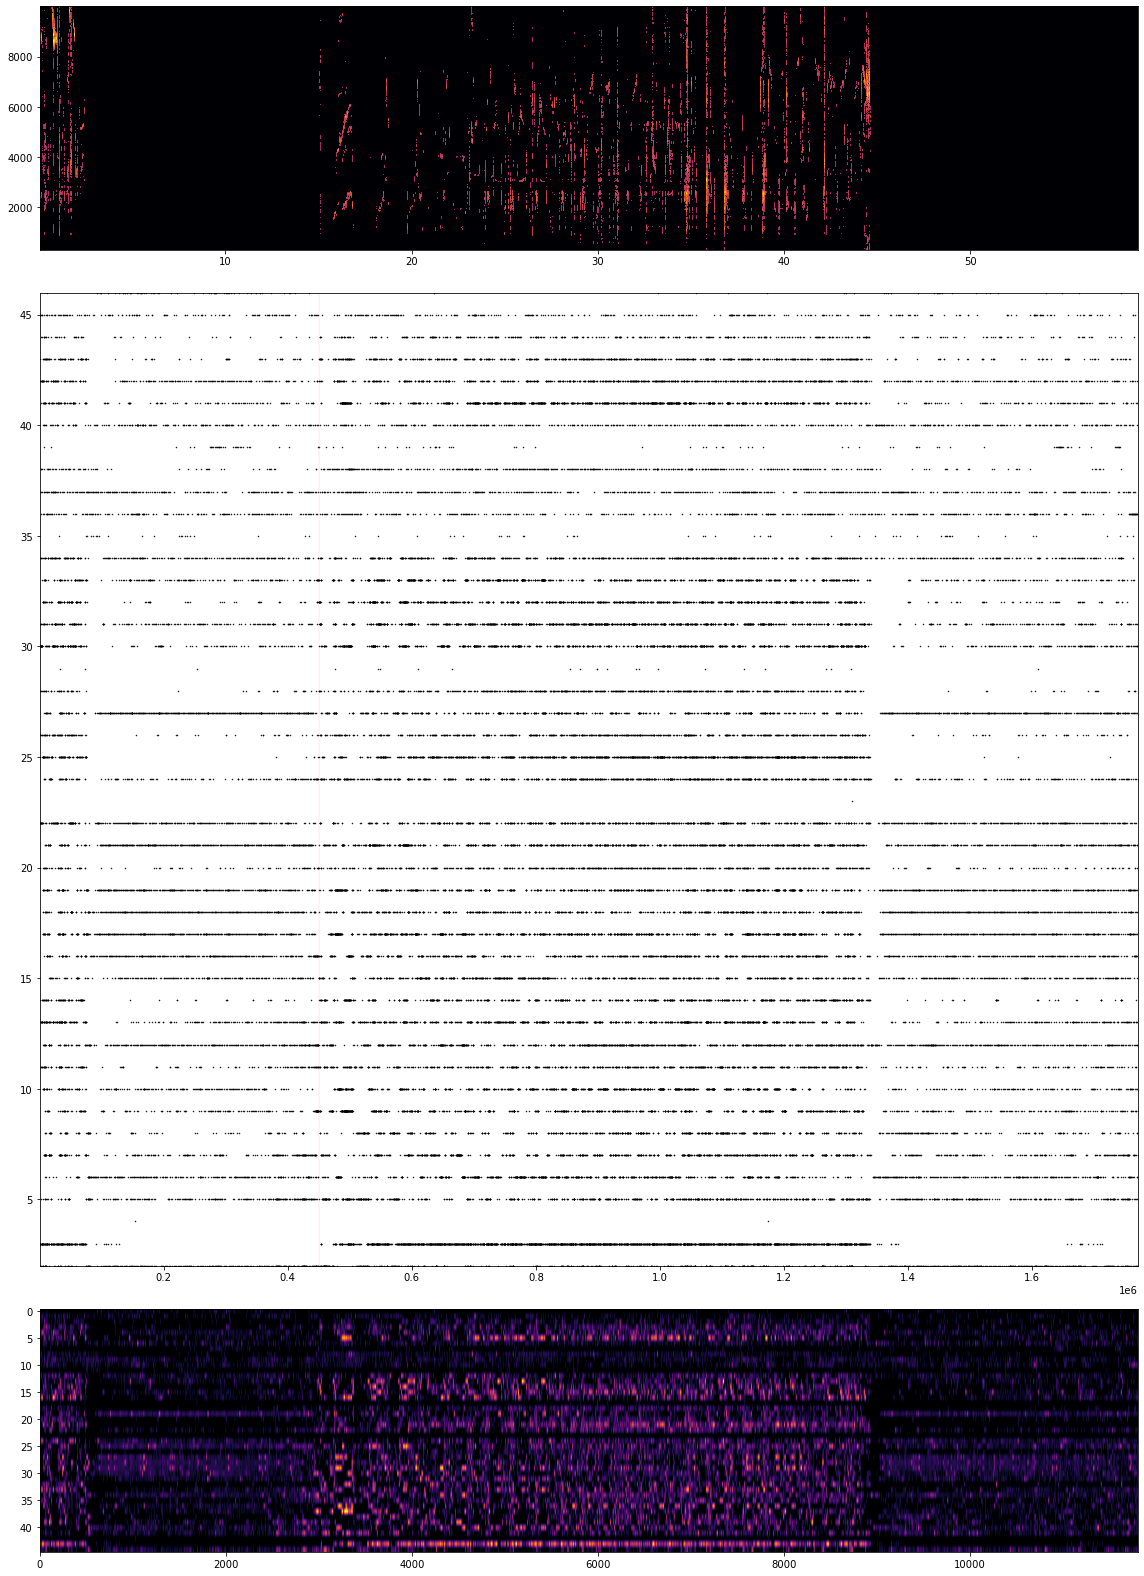

In [84]:
#### what to plot
## make a list of clusters that is just the 'good' units as per KS auto label
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])

#pick window around a bout
t_pre = - 15
t_post = 15


##Pick a bout
bout_idx = 1

def collect_bout(bout_dict, bout_idx, run_recordings, t_pre, t_post, spk_df, clu_list):
    s_f_ap = run_recordings['ap_0']._s_f_0
    s_f_nidq = run_recordings['nidq']._s_f_0
    
    ## add the length of the bout (in seconds) to the end of the segment
    t_post += int(bout_dict['len_ms'][bout_idx] * 0.001)
       
    start_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(run_recordings['ap_0']._s_f_0 * t_pre)
    end_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(run_recordings['ap_0']._s_f_0 * t_post)

    start_nidq = bout_dict['start_sample_nidq'][bout_idx] + int(run_recordings['nidq']._s_f_0 * t_pre)
    end_nidq = bout_dict['start_sample_nidq'][bout_idx] + int(run_recordings['nidq']._s_f_0 * t_post)


    # get the streams/spike array
    spk_arr = get_window_spikes(spk_df, clu_list, int(start_ap), int(end_ap))
    mic_arr = mic_stream[0, start_nidq: end_nidq]
    
    return spk_arr, mic_arr

spk_arr, mic_arr = collect_bout(bout_dict, bout_idx, run_recordings, t_pre, t_post, spk_df, clu_list)


# plot
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [2, 8, 2]}, figsize=(16, 22))

x = mic_arr.flatten()
f, t, sxx = sp.ms_spectrogram(x, s_f_nidq, f_max=12000, n_window=1024, step_ms=5, cut_off=4e-5)

#ax[0].plot(mic_arr.flatten())

ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')

plot_as_raster(spk_arr, t_0=int(-t_pre*s_f_ap), ax=ax[1])

bin_size_ms = 5
bin_size_sample = int(bin_size_ms * 0.001 *  run_recordings['ap_0']._s_f_0 )
rates_arr = pu.coarse(spk_arr, bin_size_sample)
rates_arr[np.isnan(rates_arr)] = 0

#psth = np.nansum(rates_arr, axis=0)
#ax[2].plot(psth);
ax[2].imshow(rates_arr[::-1], aspect='auto', cmap='inferno')

plt.tight_layout()

### collect all bouts

In [37]:
spk_arr_list = []
mic_arr_list = []

t_pre = - 5
t_post = 5

## get the bouts arrays
for bout_idx, start in enumerate(bout_dict['start_ms']):
    spk_arr, mic_arr = collect_bout(bout_dict, bout_idx, run_recordings, t_pre, t_post, spk_df, clu_list)
    spk_arr_list.append(spk_arr)
    mic_arr_list.append(mic_arr)
    

## make into a pandas dataframe
bout_dict['spk_arr'] = spk_arr_list
bout_dict['mic_arr'] = mic_arr_list
keys_to_df = ['start_sample_nidq', 'start_sample_ap_0', 'len_ms', 'spk_arr', 'mic_arr']

bout_dict_df = {k: bout_dict[k] for k in keys_to_df}
bout_df = pd.DataFrame.from_dict(bout_dict_df)

bout_df.head()

<ipython-input-24-f43416951db6>:5: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]


start_sample_nidq  start_sample_ap_0  len_ms  \
0             313397             470105   37010   
1            1296784            1945211   29739   
2            2220373            3330616   35610   
3            3589156            5383825   37030   
4            5673330            8510137   29449   

                                             spk_arr  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                             mic_arr  
0  [-1308, -1299, -1293, -1277, -1277, -1299, -12...  
1  [-513, -493, -491, -505, -516, -502, -510, -50...  
2  [2185, 2147, 2129, 2122, 2154, 2135, 2138, 213...  
3  [331, 327, 327, 343, 361, 351, 361, 363, 346, ...  
4  [-42, -42, -9, -8, -4, 0, -35, 3, 8, -17, -12,...

### get spectrograms and rate-grams

In [54]:
sp.ms_spectrogram(x, s_f_nidq, f_max=15000, n_window=512, step_ms=1, cut_off=4e-6)

In [67]:
f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), s_f_nidq)


bout_df['sxx_all'] = bout_df['mic_arr'].apply(lambda x: sp.ms_spectrogram(x.flatten(), s_f_nidq,  
                                                                          f_max=15000, 
                                                                          n_window=512, 
                                                                          step_ms=1, 
                                                                          cut_off=4e-6))

bout_df['sxx'] = bout_df['sxx_all'].apply(lambda x: x[2])

In [68]:
bin_size_ms = 5
bin_size_sample = int(bin_size_ms * 0.001 *  run_recordings['ap_0']._s_f_0 )

rates_arr = pu.coarse(spk_arr, bin_size_sample)

bout_df['fr_arr'] =  bout_df['spk_arr'].apply(lambda x: pu.coarse(x, bin_size_sample))

In [47]:
bout_df.head()

start_sample_nidq  start_sample_ap_0  len_ms  \
0             313397             470105   37010   
1            1296784            1945211   29739   
2            2220373            3330616   35610   
3            3589156            5383825   37030   
4            5673330            8510137   29449   

                                             spk_arr  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                             mic_arr  \
0  [-1308, -1299, -1293, -1277, -1277, -1299, -12...   
1  [-513, -493, -491, -505, -516, -502, -510, -50...   
2  [2185, 2147, 2129, 2122, 2154, 2135, 2138, 213...   
3  [331, 327, 327, 343, 361, 351, 361, 363, 346, ...   
4  [-42, -42, -9, -8, -4, 0, -35, 3, 8, -17, -12,...   

                                             sxx_all  \
0  ([312.49576810265256, 351.55773911548414, 390....   
1  ([312.49576810265256, 351.55773911548414, 390....   
2  ([312.49576810265256, 351.55773911548414, 390....   
3  ([312.49576810265256, 351.55773911548414, 390....   
4  ([312.49576810265256, 351.55773911548414, 390....   

                                                 sxx  \
0  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   
1  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   
2  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   
3  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   
4  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   

                                              fr_arr  
0  [[0.0, 0.0, 0.006666666666666667, 0.0, 0.0, 0....  
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

##### see examples

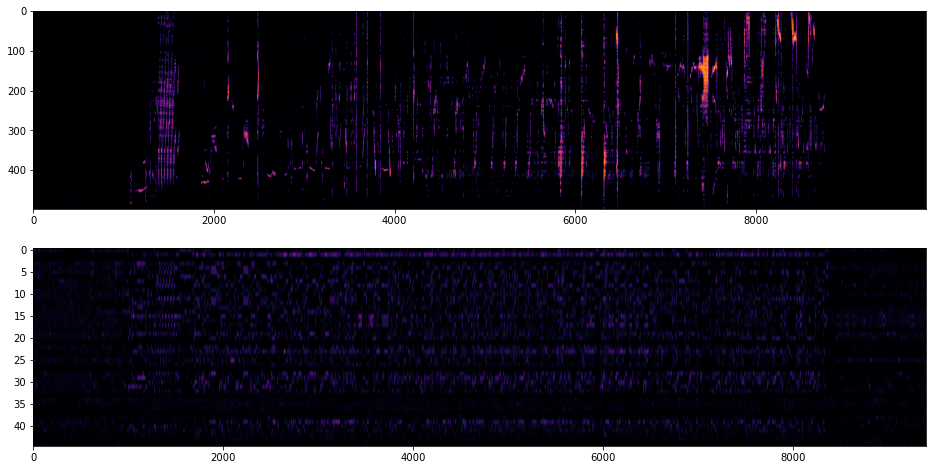

In [57]:
i_bout = 0

x = bout_df.iloc[i_bout]['mic_arr'].flatten()
f, t, sxx = sp.ms_spectrogram(x, s_f_nidq, f_max=12000, n_window=1024, step_ms=5, cut_off=4e-5)

fig, ax = plt.subplots(nrows=2, figsize=(16, 8))


ax[0].imshow(np.log(sxx[::-1]), aspect='auto', cmap='inferno')
ax[1].imshow((bout_df.iloc[i_bout]['fr_arr']*10), aspect='auto', cmap='inferno')

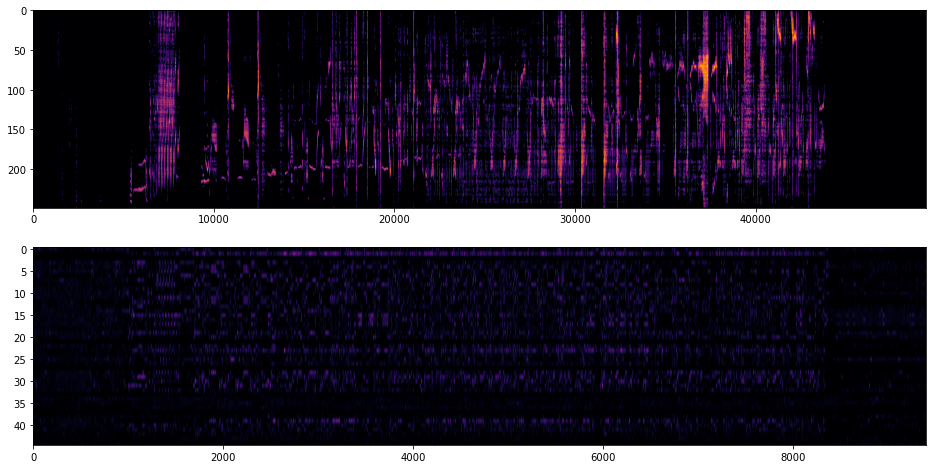

In [65]:
i_bout = 0

x = bout_df.iloc[i_bout]['mic_arr'].flatten()
f, t, sxx = sp.ms_spectrogram(x, s_f_nidq, f_max=15000, n_window=512, step_ms=1, cut_off=4e-6)

fig, ax = plt.subplots(nrows=2, figsize=(16, 8))


ax[0].imshow(np.log(sxx[::-1]), aspect='auto', cmap='inferno')
ax[1].imshow((bout_df.iloc[i_bout]['fr_arr']*10), aspect='auto', cmap='inferno')

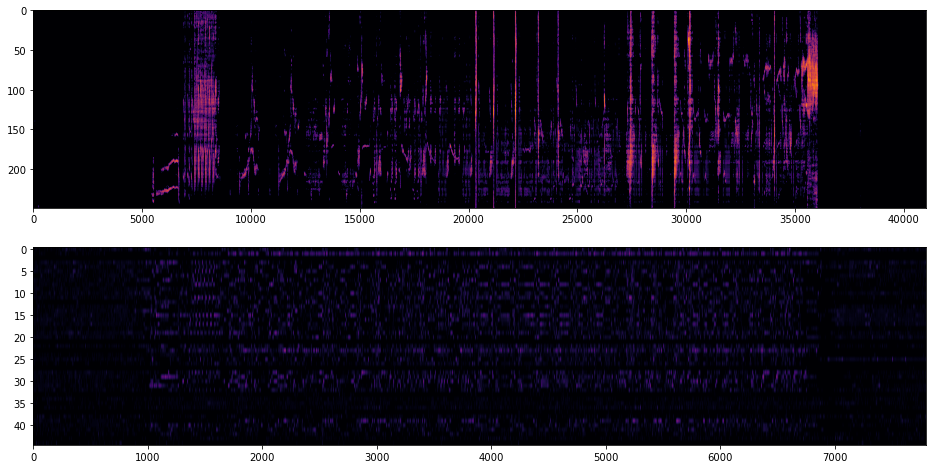

In [69]:
i_bout = 4

fig, ax = plt.subplots(nrows=2, figsize=(16, 8))

ax[0].imshow(np.log(bout_df.iloc[i_bout]['sxx'][::-1]), aspect='auto', cmap='inferno')
ax[1].imshow((bout_df.iloc[i_bout]['fr_arr']*10), aspect='auto', cmap='inferno')

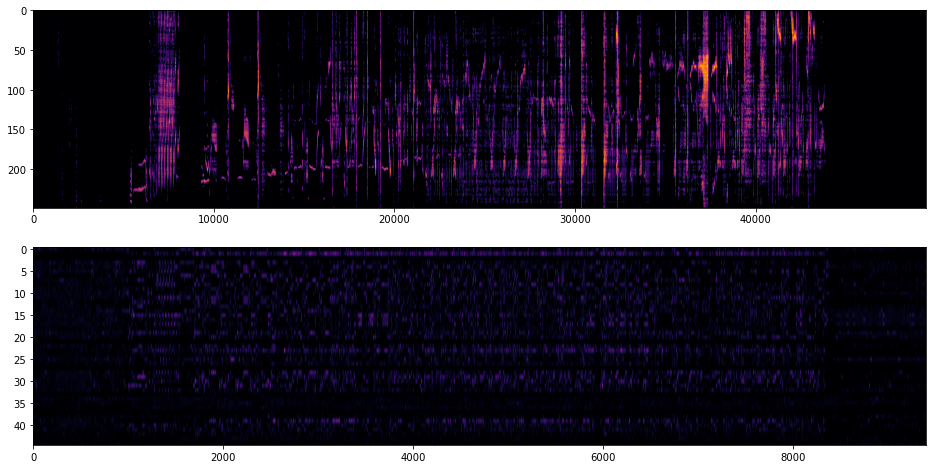

In [71]:
i_bout = 0

fig, ax = plt.subplots(nrows=2, figsize=(16, 8))

ax[0].imshow(np.log(bout_df.iloc[i_bout]['sxx'][::-1]), aspect='auto', cmap='inferno')
ax[1].imshow((bout_df.iloc[i_bout]['fr_arr']*10), aspect='auto', cmap='inferno')

### show many spectrograms

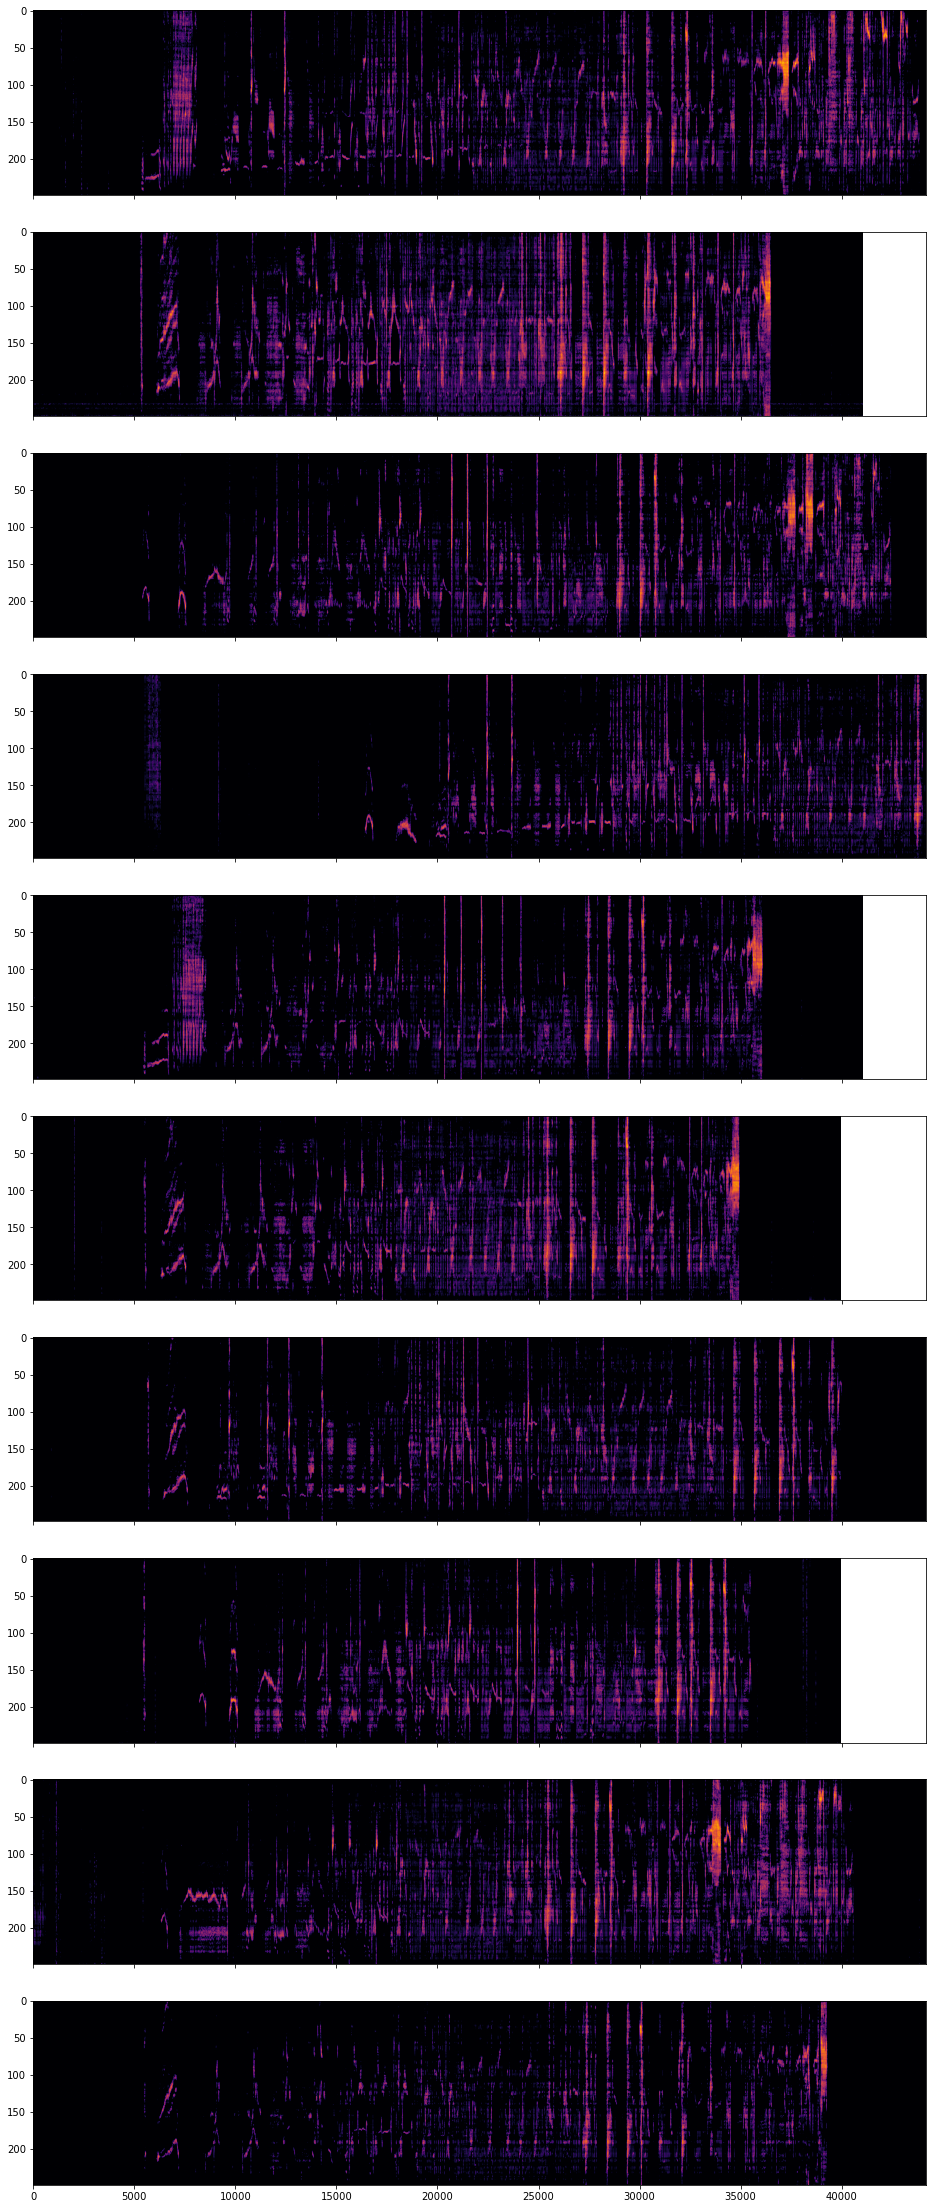

In [78]:
n_show = 10

fig, ax = plt.subplots(nrows=n_show, figsize=(16, 4*n_show), sharex=True)

show_bout = range(n_show)

for i_ax, i_bout in enumerate(show_bout):
    ax[i_ax].imshow(np.log(bout_df.iloc[i_bout]['sxx'][::-1]), aspect='auto', cmap='inferno')
    ax[i_ax].set_title('i_bout {}'.format(i_bout))

#### save the bout_df pandas to a pickle

In [77]:
bout_df_path = os.path.join(exp_struct['folders']['derived'], 'bout_df.pkl')
bout_df['bout_id'] = bout_df['start_sample_nidq']

bout_df.to_pickle(bout_df_path)
logger.info('saved bout_df to {}'.format(bout_df_path))

bout_df = pd.read_pickle(bout_df_path)
logger.info('loaded bout_df from {}'.format(bout_df_path))

#todo: make a better bout_id
bout_df['bout_id'] = bout_df['start_sample_nidq']

2021-08-18 14:10:24,241 root         INFO     saved bout_df to /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/0712_g0/bout_df.pkl
2021-08-18 14:11:21,903 root         INFO     loaded bout_df from /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-06-14/sglx/0712_g0/bout_df.pkl


## make the rollings

##### try one umap embeddin

In [14]:
import umap
from ceciestunepipe.util.dimension import umapred as dim

In [15]:
umap_win = 250

In [17]:
sx = bout_df.iloc[0]['sxx']

In [18]:
sx = bout_df.iloc[0]['sxx']
reducer, emb, rxflat = dim.rolling_umap(sx, umap_win, parametric=False, random_state=42)

KeyboardInterrupt: 

In [ ]:
plt.scatter(*emb.T);

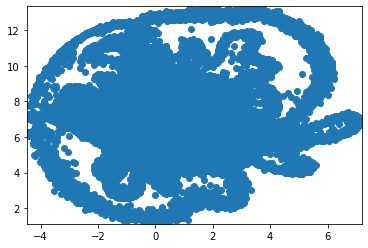

In [43]:
rt = bout_df.iloc[0]['fr_arr']

n_reducer, n_emb, n_rxflat = dim.rolling_umap(rt, umap_win, parametric=False, random_state=42)

plt.scatter(*n_emb.T);

### roll some and make the embedding


In [18]:
from ceciestunepipe.util import data as dt
import umap

In [14]:
bout_df.head(2)

start_sample_nidq  start_sample_ap_0  len_ms  \
0             313397             470105   37010   
1            1296784            1945211   29739   

                                             spk_arr  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                             mic_arr  \
0  [473, 447, 466, 489, 520, 563, 660, 658, 612, ...   
1  [-392, -358, -457, -458, -324, -196, -215, -35...   

                                             sxx_all  \
0  ([312.49576810265256, 351.55773911548414, 390....   
1  ([312.49576810265256, 351.55773911548414, 390....   

                                                 sxx  \
0  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   
1  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...   

                                              fr_arr  bout_id  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   313397  
1  [[0.0, 0.03333333333333333, 0.0, 0.0, 0.0, 0.0...  1296784

In [15]:
def make_umap_from_sample(bouts_df, feat='sxx', sample_size=0.3, window_size=20, some_bout_id=None):
    # some_bouts_id overrides sample size and uses a particular set of bouts for the embedding
    # pick some bouts
    # get the rolled spectrogram
    # make a umap embedding
    
    all_bout_id = bouts_df['bout_id'].values
    
    if some_bout_id is None:
        some_bout_id = np.random.choice(all_bout_id, int(all_bout_id.size * sample_size), replace=False)
    
    bout_sel = bouts_df['bout_id'].isin(some_bout_id)
    
    logger.info('getting rolling spectrograms for {} bouts'.format(some_bout_id.size))
    
    roll_spec = lambda sx: dt.feature_flat(dt.rolling_window(sx, window_size)) 
    
    rolled_feat = 'rolled_' + feat
    bouts_df.loc[bout_sel, rolled_feat] = bouts_df.loc[bout_sel, feat].apply(roll_spec)
    
    logger.info('stacking em up')
    all_rolled_flat_feat = np.hstack(bouts_df.loc[bout_sel, rolled_feat])
    
    logger.info('making the embedding')
    reducer = umap.UMAP(random_state=42)
    reducer.fit(all_rolled_flat_feat.T)
    logger.info('done')
    return reducer
    
#reducer = make_umap_from_sample(bout_df, window_size=umap_win)

### do some projections

In [16]:
def project_bouts(bouts_df, some_bout_id, reducer, window_size=20, feat='sxx'):
    ## do the rolling spectrogram and project for all of the some_bout_id
    bout_sel = bouts_df['bout_id'].isin(some_bout_id)
    
    logger.info('getting rolling {} umap projections for {} bouts'.format(feat, some_bout_id.size))
    roll_umap = lambda sx: dim.rolling_umap(sx, window_size, reducer)[1]
    
    bouts_df.loc[bout_sel, 'rolled_umap_{}'.format(feat)] = bouts_df.loc[bout_sel, feat].apply(roll_umap)
    bouts_df.loc[bout_sel, 'has_umap_'.format(feat)] = True
    
    return bouts_df

In [80]:
import umap
umap.__version__

'0.5.1'

In [ ]:
### pick a random sample of bouts
umap_win = 200
n_sample = 10

all_bout_id = bout_df['bout_id'].values
id_some_bout = np.random.choice(all_bout_id, n_sample, replace=False)

### make the projection with just this set of bouts
feature = 'sxx' # 'sxx' spectrogram, 'fr_arr' for firing rate. Both come in ms time step.

reducer = make_umap_from_sample(bout_df, some_bout_id=id_some_bout, window_size=umap_win)


2021-08-17 10:37:19,226 root         INFO     getting rolling spectrograms for 10 bouts
2021-08-17 11:16:13,077 root         INFO     stacking em up
2021-08-17 12:04:14,440 root         INFO     making the embedding


In [ ]:
bouts_df = project_bouts(bout_df, id_some_bout, reducer, window_size=umap_win)

In [ ]:
### make the projection with just this set of bouts
feature = 'fr_arr' # 'sxx' spectrogram, 'fr_arr' for firing rate. Both come in ms time step.

reducer = make_umap_from_sample(bout_df, some_bout_id=id_some_bout, window_size=umap_win)
bouts_df = project_bouts(bout_df, id_some_bout, reducer, window_size=umap_win)

In [34]:
id_some_bout

array([ 40385696,    313397,  76993038,  99878152,   2220373,   8248897,
        39407508, 134368321,  82718967, 327705904])

In [36]:
all_rolled_flat_sx = np.hstack(bout_df['sxx_roll'])

In [37]:
all_rolled_flat_sx.shape

(3440, 1722004)

In [ ]:
reducer_sx = umap.UMAP(random_state=42)

reducer_sx.fit(all_rolled_flat_sx.T)

In [ ]:
all_rolled_flat_fr = np.hstack(bout_df['fr_roll'])

reducer_fr = umap.UMAP(random_state=42)

reducer_fr.fit(all_rolled_flat_fr.T)

In [107]:
bout_dict

{'template': memmap([ -275,  -258,  -245, ..., -1737, -1734, -1750], dtype=int16),
 's_f': 20000,
 's_f_nidq': 19999.75,
 's_f_ap_0': 30000.0,
 'start_ms': array([   15670,    64840,   111020,   179460,   283670,   369580,
          412450,   463160,  1327100,  1375900,  1422920,  1476900,
         1512130,  1585770,  1625000,  1909140,  1970400,  2019310,
         2653600,  2767500,  3010180,  3130470,  3213900,  3274500,
         3331000,  3383830,  3447100,  3849700,  3878390,  3919670,
         3973890,  4028380,  4136000,  4227180,  4321500,  4993970,
         5110290,  5263800,  5439420,  5560350,  6410950,  6718500,
         6771670, 16330800, 16385500, 17007440, 17237000, 17388300]),
 'len_ms': array([37010, 29739, 35610, 37030, 29449, 28370, 33170, 28939, 34000,
        32719, 34079, 24199, 27209, 25860, 25789, 40589, 34500, 37289,
        32000, 48920, 31970, 51390, 30639, 30679, 33000, 29869, 29200,
        27420, 20510, 32029, 31910, 35039, 44199, 42769, 41720, 43279,
     

### roll all
-discarded as too memory consuming

In [ ]:
bout_df['sxx_roll'] = bout_df['sxx'].apply(lambda sx: dt.feature_flat(dt.rolling_window(sx, umap_win)))
bout_df['fr_roll'] = bout_df['fr_arr'].apply(lambda sx: dt.feature_flat(dt.rolling_window(sx, umap_win)))

bout_df_path = os.path.join(exp_struct['folders']['derived'], 'bout_df_roll-{}.pkl'.format(umap_win))

#bout_df.to_pickle(bout_df_path)
#logger.info('saved bout_df to {}'.format(bout_df_path))

#bout_df.to_pickle(bout_df_path)
bout_df = pd.read_pickle(bout_df_path)
logger.info('loaded bout_df from {}'.format(bout_df_path))